<a href="https://colab.research.google.com/github/ArVincci/Flight-Delay-Challenge/blob/main/ExamenCopa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration

In [1]:
# Loading the data set

import pandas as pd

df=pd.read_csv('flight_data-2025-05-21.csv')

df.info()
df.describe()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Row_ID                 5000 non-null   object
 1   Flight_Number          5000 non-null   object
 2   Carrier                5000 non-null   object
 3   Scheduled_Departure    5000 non-null   object
 4   Scheduled_Arrival      5000 non-null   object
 5   Actual_Arrival         5000 non-null   object
 6   Distance               5000 non-null   int64 
 7   Aircraft_Type          5000 non-null   object
 8   Weather_Condition      5000 non-null   object
 9   Departure_Airport      5000 non-null   object
 10  Arrival_Airport        5000 non-null   object
 11  Time_Block             5000 non-null   object
 12  Arrival_Delay_Minutes  5000 non-null   int64 
 13  Delayed_Over_15_Min    5000 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 547.0+ KB


,Row_ID,Flight_Number,Carrier,Scheduled_Departure,Scheduled_Arrival,Actual_Arrival,Distance,Aircraft_Type,Weather_Condition,Departure_Airport,Arrival_Airport,Time_Block,Arrival_Delay_Minutes,Delayed_Over_15_Min
0,FLIGHT_1,CM874,CM,2023-02-28 21:00:00,2023-02-28 23:18:00,2023-02-28 23:44:00,1120,B737-MAX9,Bad,PTY,GYE,PM,26,1
1,FLIGHT_2,CM201,CM,2023-04-13 10:00:00,2023-04-13 13:17:00,2023-04-13 13:21:00,1760,B737-MAX9,Good,PTY,LIM,AM,4,0
2,FLIGHT_3,CM873,CM,2023-04-14 06:00:00,2023-04-14 08:27:00,2023-04-14 08:35:00,1120,B737-800,Good,PTY,GYE,AM,8,0
3,FLIGHT_4,CM102,CM,2023-01-23 20:00:00,2023-01-24 02:01:00,2023-01-24 02:00:00,2880,B737-MAX9,Good,PTY,LAX,PM,-1,0
4,FLIGHT_5,CM937,CM,2023-05-06 06:00:00,2023-05-06 11:49:00,2023-05-06 11:40:00,2880,B737-800,Good,PTY,LAX,AM,-9,0


# Data preparation

In [2]:
# Convert datetime columns
df['Scheduled_Departure'] = pd.to_datetime(df['Scheduled_Departure'])
df['Scheduled_Arrival'] = pd.to_datetime(df['Scheduled_Arrival'])
df['Actual_Arrival'] = pd.to_datetime(df['Actual_Arrival'])

# Feature engineering: extract useful time-based features
df['Scheduled_Departure_Hour'] = df['Scheduled_Departure'].dt.hour
df['Scheduled_Departure_DayOfWeek'] = df['Scheduled_Departure'].dt.dayofweek  #i.e: 0=Monday
df['Flight_Duration_Minutes'] = (df['Scheduled_Arrival'] - df['Scheduled_Departure']).dt.total_seconds() / 60

# Drop unused or redundant fields
df = df.drop(columns=['Row_ID', 'Carrier', 'Flight_Number', 'Scheduled_Departure', 'Scheduled_Arrival', 'Actual_Arrival'])

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Aircraft_Type', 'Weather_Condition', 'Departure_Airport', 'Arrival_Airport', 'Time_Block'], drop_first=True)

# Separate features and target
X = df.drop(columns=['Arrival_Delay_Minutes', 'Delayed_Over_15_Min'])
y = df['Delayed_Over_15_Min']

# Checking how's the data looking
print(X.head())
print(y.head())

   Distance  Scheduled_Departure_Hour  Scheduled_Departure_DayOfWeek  \
0      1120                        21                              1   
1      1760                        10                              3   
2      1120                         6                              4   
3      2880                        20                              0   
4      2880                         6                              5   

   Flight_Duration_Minutes  Aircraft_Type_B737-MAX9  Weather_Condition_Good  \
0                    138.0                     True                   False   
1                    197.0                     True                    True   
2                    147.0                    False                    True   
3                    361.0                     True                    True   
4                    349.0                    False                    True   

   Weather_Condition_Moderate  Arrival_Airport_CUN  Arrival_Airport_EZE  \
0                

# Split into training and testing data

In [3]:
from sklearn.model_selection import train_test_split

#test size 30% from dataset, random state 42 for Reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building the model (Random Forest)

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluating the model

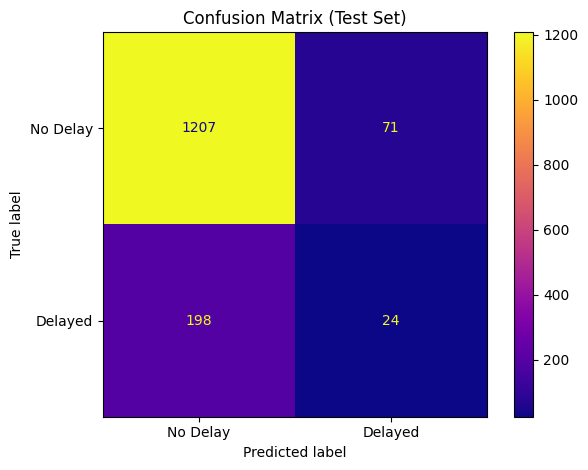


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      1278
           1       0.25      0.11      0.15       222

    accuracy                           0.82      1500
   macro avg       0.56      0.53      0.53      1500
weighted avg       0.77      0.82      0.79      1500

AUC Score: 0.6463893470935724


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_names = ['No Delay', 'Delayed']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='plasma')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

# Print classification metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

# Feature importance

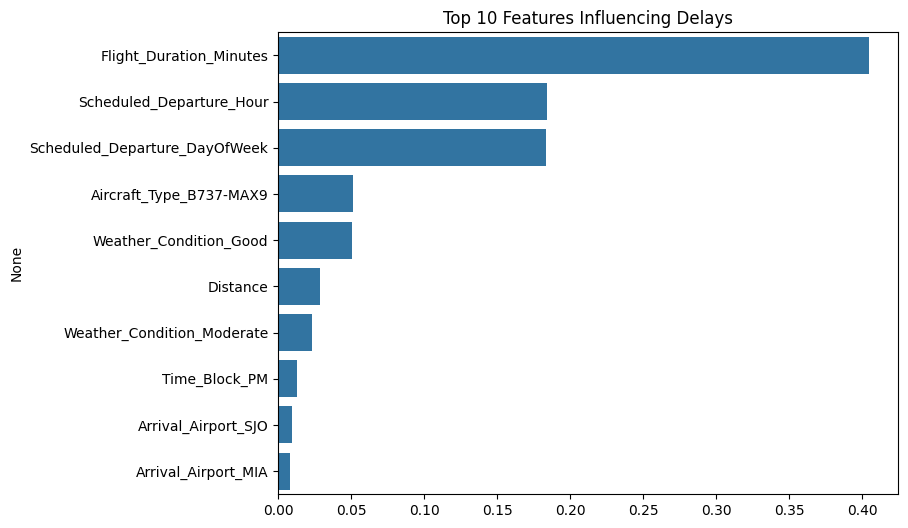

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Features Influencing Delays")
plt.show()